In [2]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cifar-10-batches-py


In [4]:
# Load dataset
data_path = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

local_data_dir = "/content/drive/My Drive/data"  #tempfile.mkdtemp()  # Change this as needed
tf.gfile.MakeDirs(local_data_dir)

url = urllib.request.urlopen(data_path)
archive = tarfile.open(fileobj=url, mode='r|gz') # read a .tar.gz stream
archive.extractall(local_data_dir)
url.close()
archive.close()
print('extracted data files to %s' % local_data_dir)

extracted data files to /content/drive/My Drive/data


In [0]:
# Preprocessing
def unpickle(filename):
  with open(filename, 'rb') as fo:
    return cPickle.load(fo, encoding='latin1')
  
def reshape_flattened_image_batch(flat_image_batch):
  return flat_image_batch.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])  # convert from NCHW to NHWC

def combine_batches(batch_list):
  images = np.vstack([reshape_flattened_image_batch(batch['data'])
                      for batch in batch_list])
  labels = np.vstack([np.array(batch['labels']) for batch in batch_list]).reshape(-1, 1)
  return {'images': images, 'labels': labels}
  

train_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_%d' % i))
    for i in range(1,5)
])

valid_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_5'))])

test_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/test_batch'))])
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [0.5, 0.5]"""
  images = data_dict['images']
  data_dict['images'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

data_variance = np.var(train_data_dict['images'] / 255.0)

In [0]:
# Model: PixelCNN for image reconstruction
def residual_stack(h, num_hiddens, num_residual_layers, num_residual_hiddens):
  for i in range(num_residual_layers):
    h_i = tf.nn.relu(h)

    h_i = snt.Conv2D(
        output_channels=num_residual_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="res3x3_%d" % i)(h_i)
    h_i = tf.nn.relu(h_i)

    h_i = snt.Conv2D(
        output_channels=num_hiddens,
        kernel_shape=(1, 1),
        stride=(1, 1),
        name="res1x1_%d" % i)(h_i)
    h += h_i
  return tf.nn.relu(h)

# Speaker and Listener
class Speaker(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='speaker'):
    super(Speaker, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
    self.pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")
    
  def _build(self, x):
    h = snt.Conv2D(
        output_channels=self._num_hiddens / 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")(x)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")(h)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")(h)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    

    z = self.pre_vq_conv1(h)

    return z

class Listener(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='listener'):
    super(Listener, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
    if vq_use_ema:
      self.vq_vae = snt.nets.VectorQuantizerEMA(
          embedding_dim=embedding_dim,
          num_embeddings=num_embeddings,
          commitment_cost=commitment_cost,
          decay=decay)
    else:
      self.vq_vae = snt.nets.VectorQuantizer(
          embedding_dim=embedding_dim,
          num_embeddings=num_embeddings,
          commitment_cost=commitment_cost)
  
  def _build(self, z):
    # VQ-VAE
    vq_output_train = self.vq_vae(z, is_training=True)
    z = vq_output_train["quantize"]
  
    h = snt.Conv2D(
      output_channels=self._num_hiddens,
      kernel_shape=(3, 3),
      stride=(1, 1),
      name="dec_1")(z)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

    h = snt.Conv2DTranspose(
        output_channels=int(self._num_hiddens / 2),
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")(h)
    h = tf.nn.relu(h)

    x_recon = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")(h)
        

    return x_recon

In [0]:
# Computational graph

tf.reset_default_graph()

# Hyperparameters
batch_size = 32
image_size = 32
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 64      # K  
num_embeddings = 512    # D
commitment_cost = 0.25

# Use EMA update
vq_use_ema = False
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")
# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)
    .batch(batch_size)).make_one_shot_iterator()
valid_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)
    .batch(batch_size)).make_initializable_iterator()
exp_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10)
    .repeat(-1)
    .batch(1)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()
valid_dataset_batch = valid_dataset_iterator.get_next()
exp_dataset_batch = exp_dataset_iterator.get_next()

def get_images(sess, subset='train'):
  if subset == 'train':
    return sess.run(train_dataset_batch)['images']
  elif subset == 'valid':
    return sess.run(valid_dataset_batch)['images']
  elif subset == 'exp':
    return sess.run(exp_dataset_batch)['images']

# Build modules
speaker = Speaker(num_hiddens, num_residual_layers, num_residual_hiddens)
listener = Listener(num_hiddens, num_residual_layers, num_residual_hiddens)
saver = tf.train.Saver()


x = tf.placeholder(tf.float32, shape=(None, image_size, image_size, 3))
z = speaker(x)

# For training
vq_output_train = listener.vq_vae(z, is_training=True)
x_recon = listener(z)
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation
vq_output_eval = listener.vq_vae(z, is_training=False)
z_eval = vq_output_eval["encodings"]                   # Embedding message
z_ind = vq_output_eval["encoding_indices"]             # Symbolic message
x_recon_eval = listener(vq_output_eval["quantize"])    # Reconstruction
perplexity = vq_output_train["perplexity"]             # Perplexity

# For experiment
z_in = tf.placeholder(tf.int32, shape=(1, 8, 8))
z_quantized = listener.vq_vae.quantize(z_in)
x_recon_ind = listener(z_quantized)                        # Reconstruction with z


optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Train.
num_training_updates = 50000

train_res_recon_error = []
train_res_perplexity = []

saver.restore(sess, "/tmp/model.ckpt")

for i in xrange(num_training_updates):
  feed_dict = {x: get_images(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                    feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 100 == 0:
    saver.save(sess, "/tmp/model.ckpt")
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    print()

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
100 iterations
recon_error: 0.550
perplexity: 6.666

200 iterations
recon_error: 0.285
perplexity: 17.753

300 iterations
recon_error: 0.237
perplexity: 16.799

400 iterations
recon_error: 0.221
perplexity: 15.550

500 iterations
recon_error: 0.211
perplexity: 16.510

600 iterations
recon_error: 0.198
perplexity: 17.701

700 iterations
recon_error: 0.191
perplexity: 18.753

800 iterations
recon_error: 0.177
perplexity: 21.455

900 iterations
recon_error: 0.172
perplexity: 24.106

1000 iterations
recon_error: 0.169
perplexity: 26.831

1100 iterations
recon_error: 0.156
perplexity: 29.366

1200 iterations
recon_error: 0.152
perplexity: 31.165

1300 iterations
recon_error: 0.147
perplexity: 33.212

1400 iterations
recon_error: 0.142
perplexity: 34.958

1500 iterations
recon_error: 0.139
perplexity: 37.377

1600 iterations
recon_error: 0.135
perplexity: 38.821

1700 iterations
recon_error: 0.129
perplexity: 40.684

1800 iterations
r

Text(0.5, 1.0, 'Perplexity.')

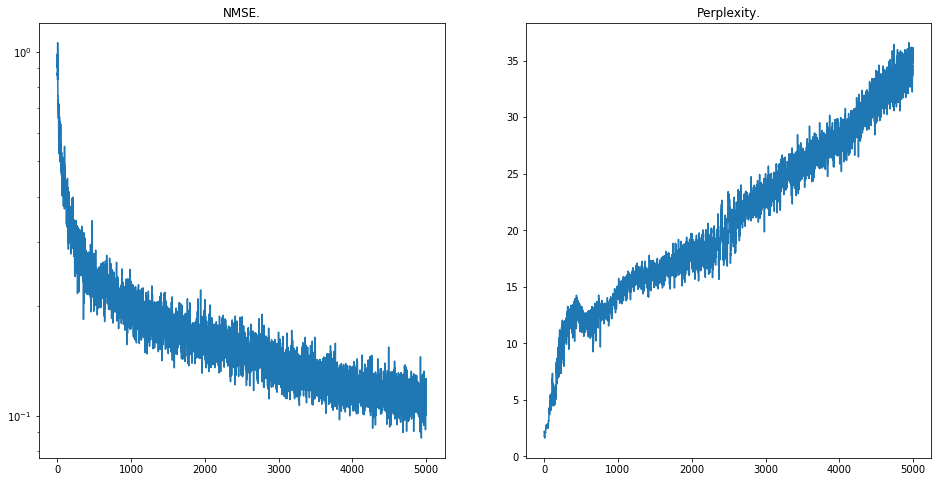

In [9]:
# Plot loss
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Perplexity.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


(-0.5, 255.5, 127.5, -0.5)

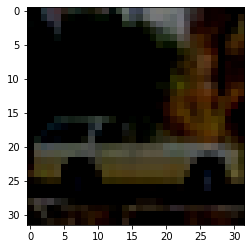

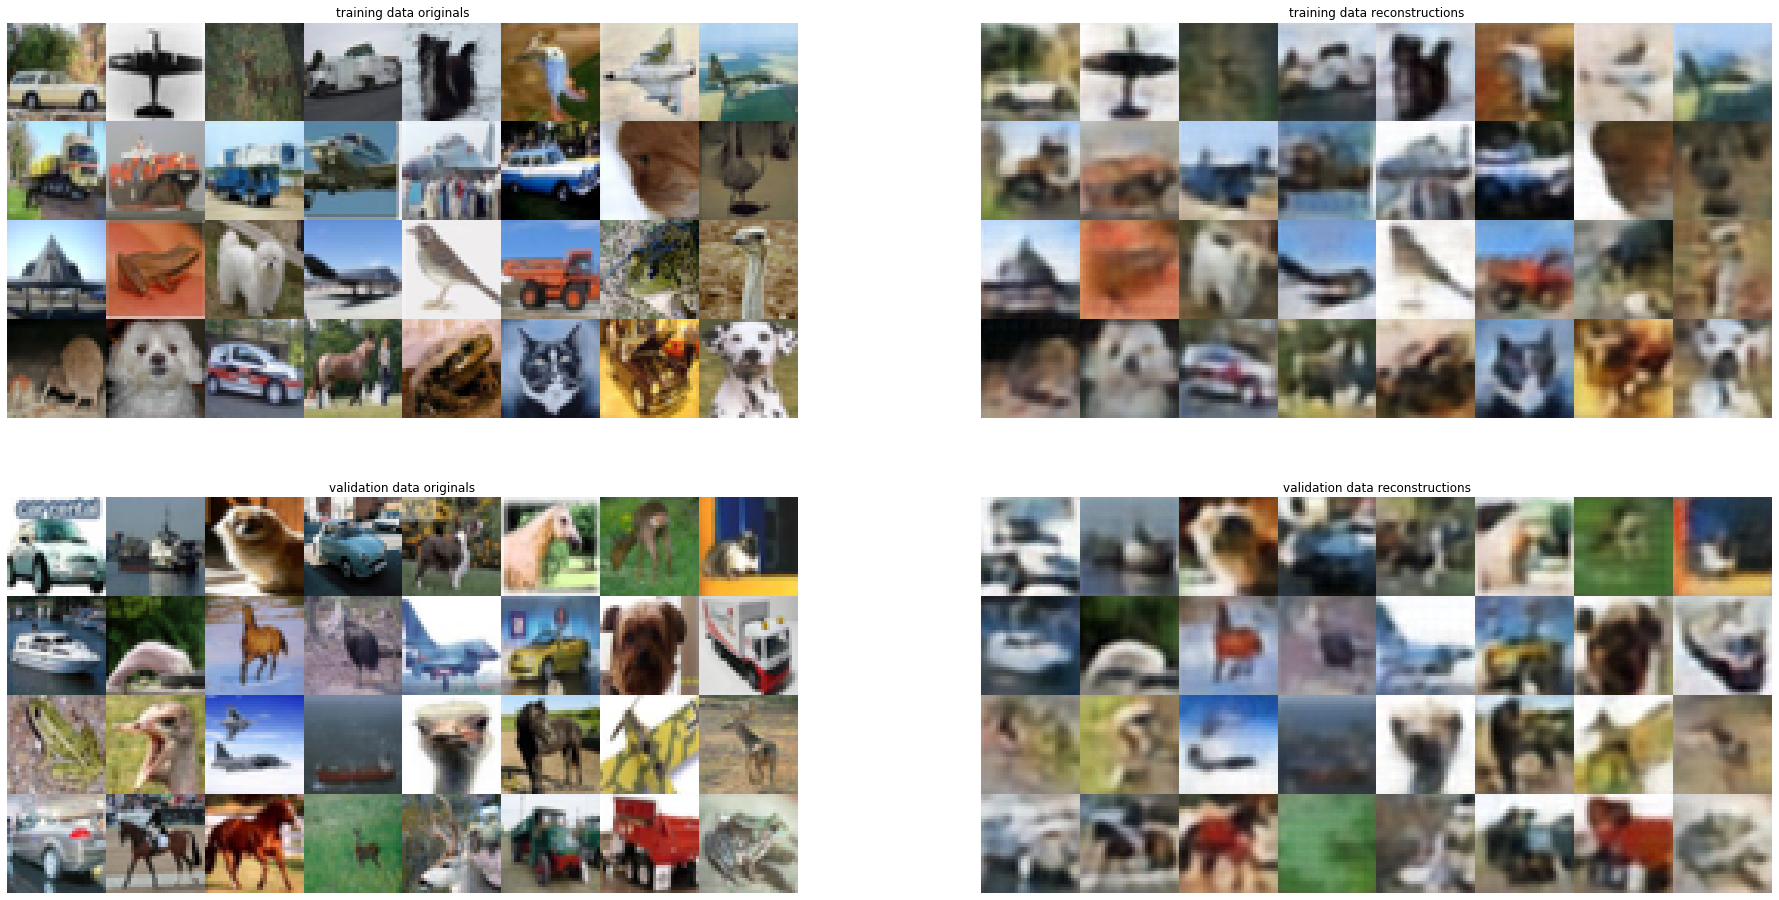

In [10]:
# Reconstructions
sess.run(valid_dataset_iterator.initializer)
train_originals = get_images(sess, subset='train')
train_reconstructions = sess.run(x_recon_eval, feed_dict={x: train_originals})
valid_originals = get_images(sess, subset='valid')
valid_reconstructions = sess.run(x_recon_eval, feed_dict={x: valid_originals})
def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5

print(train_originals[0].shape)
plt.figure()
plt.imshow(train_originals[0])cast_and_normalise_images

f = plt.figure(figsize=(32,16))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_originals),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_originals),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[361 492 492 492 361 361 492 492 361 209 446 361 361 209 361 361 361 361
  361 361 361 361 361 361 361 361 361 361 361 361 361 361 361 361 361 361
  344 259 361 361 361 361 361 344 344 361 361 361 361 361 361 344 344 344
  361 361 361 361 361 361 361 361 361 361]]


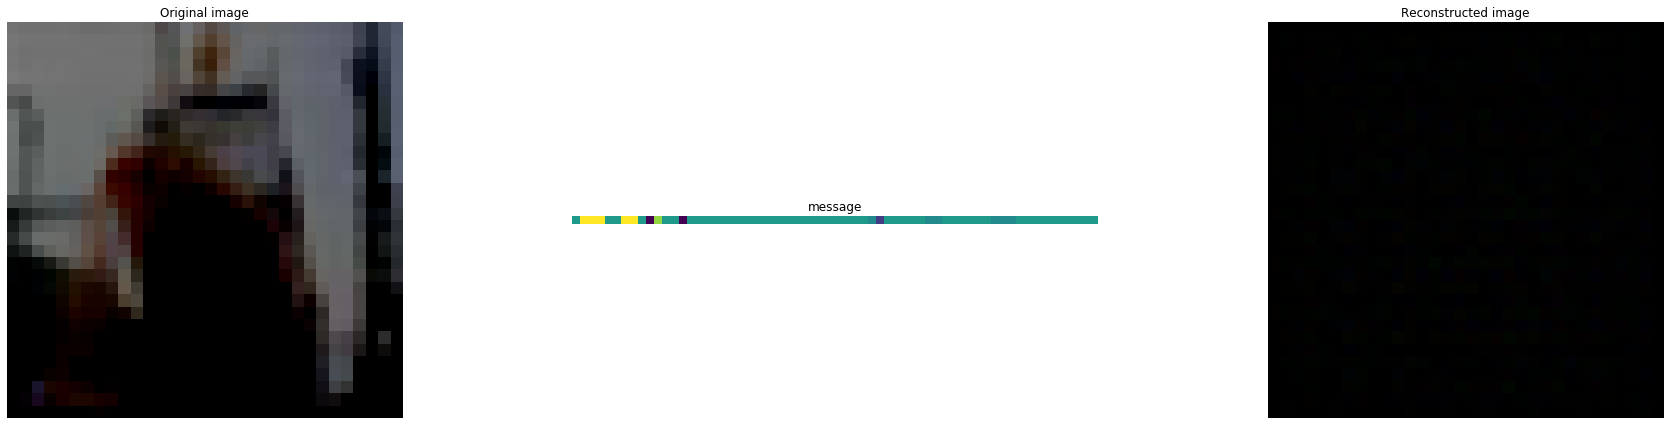

In [116]:
# Language structure experiment
#sess.run(exp_dataset_iterator.initializer)
img = get_images(sess, subset='train')[0]
img_batch = np.expand_dims(img, axis=0)

z_samples = sess.run(z_eval, feed_dict={x: img_batch})
z_scalar = np.asarray([np.where(r==1)[0][0] for r in z_samples])
z_scalar = np.expand_dims(z_scalar, 0)
z_img = np.resize(z_scalar,(8,8))

x_recons_exp = sess.run(x_recon_eval, feed_dict={x: img_batch})

print(z_scalar)


f = plt.figure(figsize=(32,16))

ax = f.add_subplot(2,3,1)
ax.imshow(img,
          interpolation='nearest')
ax.set_title('Original image')
ax.axis('off') 

ax = f.add_subplot(2,3,2)
ax.imshow(z_scalar,
          interpolation='nearest')
ax.set_title('message')
ax.axis('off') 

ax = f.add_subplot(2,3,3)
ax.imshow(x_recons_exp.squeeze(0),
          interpolation='nearest')
ax.set_title('Reconstructed image')
ax.axis('off') 

fig = plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 8, 8, 64)
(1, 8, 8)


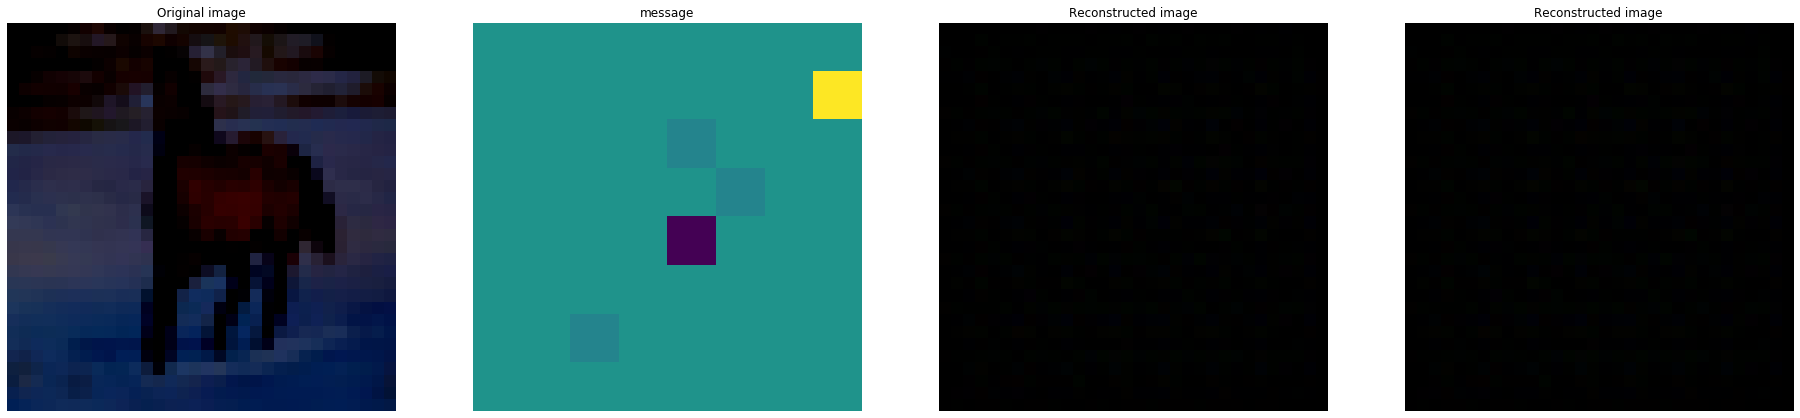

In [122]:
# Language structure experiment
img = get_images(sess, subset='exp')[0]
img_batch = np.expand_dims(img, axis=0)


z_out = sess.run(z, feed_dict={x: img_batch})
print(z_out.shape)

z_ind_sample = sess.run(z_ind, feed_dict={x: img_batch})
print(z_ind_sample.shape)

z_quantized_sample = sess.run(z_quantized, feed_dict={z_in: z_ind_sample})

x_recons_exp = sess.run(x_recon_eval, feed_dict={x: img_batch})
x_recon_ind_exp = sess.run(x_recon_ind, feed_dict={z_in: z_ind_sample})


f = plt.figure(figsize=(32,16))

ax = f.add_subplot(2,4,1)
ax.imshow(img,
          interpolation='nearest')
ax.set_title('Original image')
ax.axis('off') 

ax = f.add_subplot(2,4,2)
ax.imshow(z_ind_sample.squeeze(0),
          interpolation='nearest')
ax.set_title('message')
ax.axis('off') 

ax = f.add_subplot(2,4,3)
ax.imshow(x_recons_exp.squeeze(0),
          interpolation='nearest')
ax.set_title('Reconstructed image')
ax.axis('off') 

ax = f.add_subplot(2,4,4)
ax.imshow(x_recon_ind_exp.squeeze(0),
          interpolation='nearest')
ax.set_title('Reconstructed image')
ax.axis('off') 

fig = plt.show()